<a href="https://colab.research.google.com/github/maiormarso/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LSD_DS_213_assignment_ridge_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*
# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &           
        (df['SALE_PRICE'] >=100000) &   
        (df['SALE_PRICE'] <= 2000000))
df = df[mask]

In [26]:
top10

Index(['FLUSHING-NORTH', 'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)',
       'BEDFORD STUYVESANT', 'BOROUGH PARK', 'UPPER WEST SIDE (59-79)',
       'GRAMERCY', 'ASTORIA', 'FOREST HILLS', 'EAST NEW YORK'],
      dtype='object')

In [27]:
import pandas as pd
import pandas_profiling
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"],infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3164
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [28]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2517, 21), (647, 21))

In [29]:
train.profile_report()

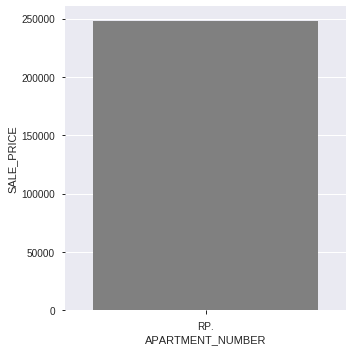

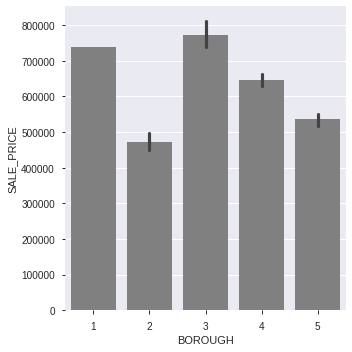

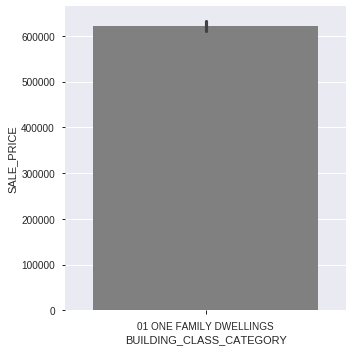

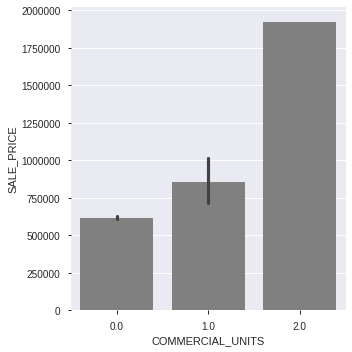

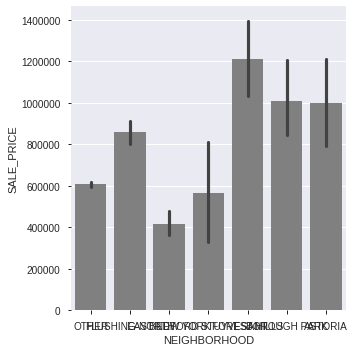

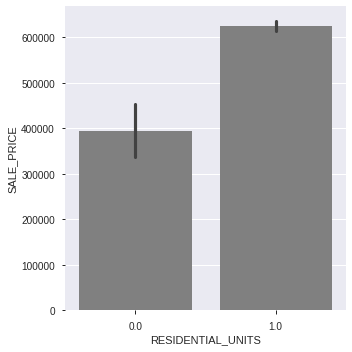

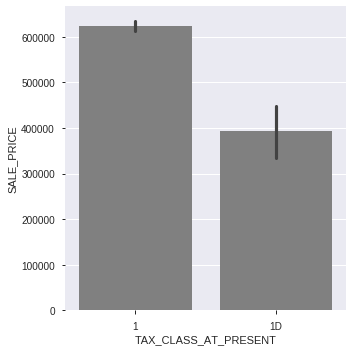

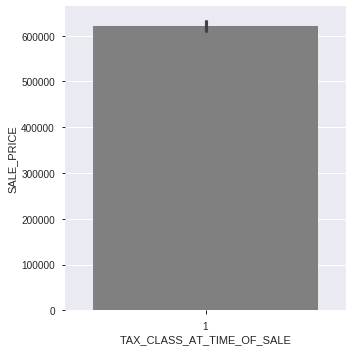

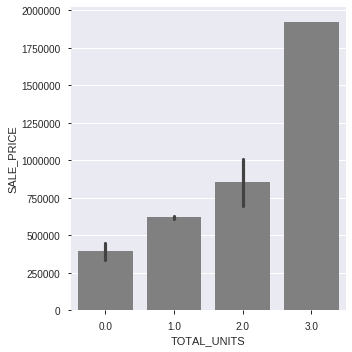

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

for col in sorted(train.columns):
  if train[col].nunique() < 10:
    try:
      sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='gray')
      plt.show()
    except:
      pass  

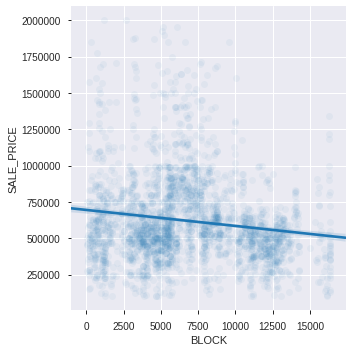

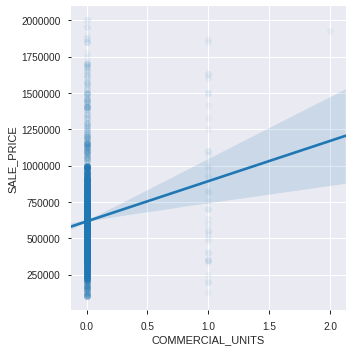

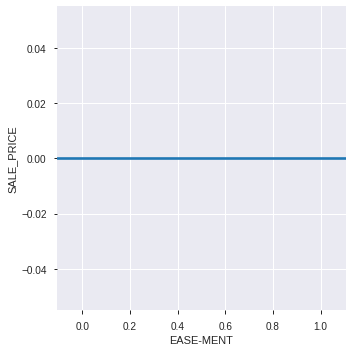

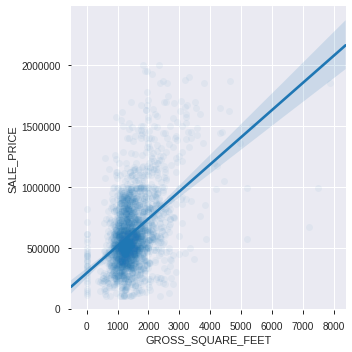

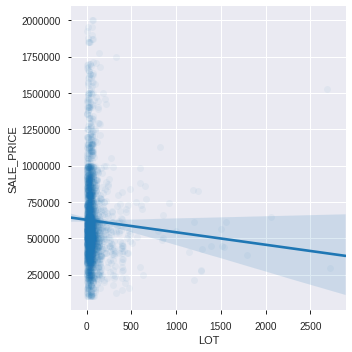

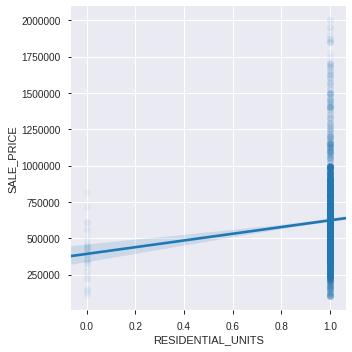

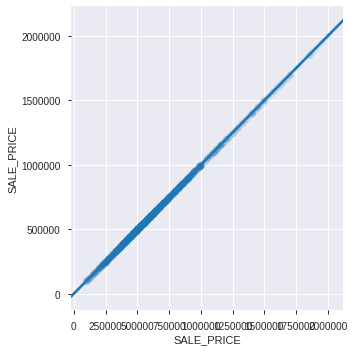

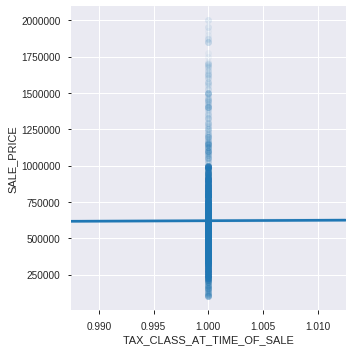

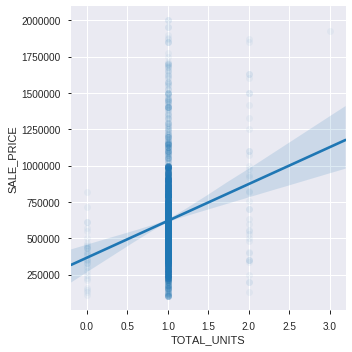

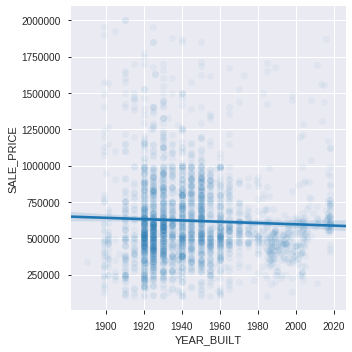

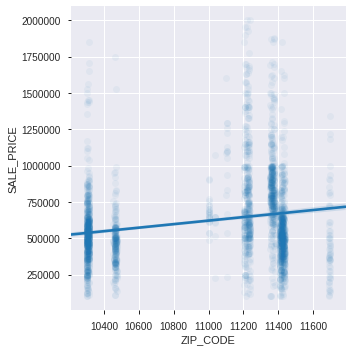

In [31]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
  plt.show()

#OneHotEncoder

In [32]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,7,OTHER,2368,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
ADDRESS,2517,2507,22-40 93RD STREET,2,NaT,NaT


In [0]:
target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number').columns.drop(target).tolist()
categoricals = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_categoricals = [col for col in categoricals
                                if train[col].nunique() <= 50]
features = numerics + low_cardinality_categoricals

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [34]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
# encoder.fit_transform(X_train) copy and rename


X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded= encoder.transform(X_test)
X_train_encoded.head()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,5495,801,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
61,7918,72,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
78,4210,19,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
108,5212,69,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
111,7930,121,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


John Humenczuk 7:34 PM
df.drop(['COLUMN_NAME'], axis = 1, inplace = True)   what is this for saledate

In [0]:
X_train_encoded = X_train_encoded.drop(columns='EASE-MENT')
X_test_encoded = X_test_encoded.drop(columns='EASE-MENT')
#drops the easement which is never used.

In [0]:
# Filter these warnings:
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='scipy')

In [37]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
  print(f'{k}features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)

  model = RidgeCV()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1features
Test MAE: $185,818 

2features
Test MAE: $184,788 

3features
Test MAE: $184,786 

4features
Test MAE: $185,835 

5features
Test MAE: $184,054 

6features
Test MAE: $178,896 

7features
Test MAE: $179,334 

8features
Test MAE: $179,009 

9features
Test MAE: $174,059 

10features
Test MAE: $165,802 

11features
Test MAE: $165,472 

12features
Test MAE: $164,591 

13features
Test MAE: $166,113 

14features
Test MAE: $165,245 

15features
Test MAE: $165,246 

16features
Test MAE: $164,983 

17features
Test MAE: $164,983 

18features
Test MAE: $164,812 

19features
Test MAE: $164,812 

20features
Test MAE: $164,850 

21features
Test MAE: $164,850 

22features
Test MAE: $160,475 

23features
Test MAE: $160,478 

24features
Test MAE: $160,479 

25features
Test MAE: $160,156 

26features
Test MAE: $160,295 

27features
Test MAE: $160,220 

28features
Test MAE: $160,179 

29features
Test MAE: $160,154 

30features
Test MAE: $161,395 

31features
Test MAE: $161,432 

32features
Test M

In [38]:
# What's going on with k=26?
k = 26

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# for k in range(1, len(X_train_encoded.columns)+1)
#   print(f'(k) features')

selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f} \n')

# Which features were selected?
all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]

pd.options.display.float_format = '{:,.0f}'.format
pd.Series(model.coef_, selected_names)

Test MAE: $160,352 



BLOCK                                -97,396
ZIP_CODE                            -137,791
RESIDENTIAL_UNITS                    -13,554
COMMERCIAL_UNITS                       3,084
TOTAL_UNITS                           -6,388
GROSS_SQUARE_FEET                    122,987
BOROUGH_3                              6,177
BOROUGH_2                           -162,577
BOROUGH_5                           -242,115
NEIGHBORHOOD_OTHER                    62,367
NEIGHBORHOOD_FLUSHING-NORTH           66,791
NEIGHBORHOOD_FOREST HILLS             47,330
NEIGHBORHOOD_BOROUGH PARK             31,481
TAX_CLASS_AT_PRESENT_1               -13,554
BUILDING_CLASS_AT_PRESENT_A5          -1,169
BUILDING_CLASS_AT_PRESENT_A3           9,000
BUILDING_CLASS_AT_PRESENT_S1              27
BUILDING_CLASS_AT_PRESENT_A4           3,060
BUILDING_CLASS_AT_PRESENT_A6          -4,736
BUILDING_CLASS_AT_PRESENT_S0           9,950
BUILDING_CLASS_AT_TIME_OF_SALE_A5    -23,667
BUILDING_CLASS_AT_TIME_OF_SALE_A3      9,000
BUILDING_C

In [43]:
# Whick features were used?
k = 27
selector = SelectKBest(score_func=f_regression)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
seclected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
print('\nFeatures not selected')
for name in unselected_names:
  print(name)     

Features selected:
BLOCK
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_S0

Features not selected
LOT
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_P

##Fit a ridge regression model with multiple features.
Get mean absolute error for the test set